# Model fine-tuning and evaluation

In this notebook we fine-tune a ResNet model using PyTorch, and evaluate the resulting waste classification model.

In [51]:
# Load libraries

import numpy as np

from matplotlib import pyplot as plt

from torch import Tensor
from torch import unsqueeze
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch import no_grad
from torch import save
from torch import argmax

from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

## Dataset 

The dataset used was [RealWaste](https://archive.ics.uci.edu/dataset/908/realwaste) (which also has the GitHub [link](https://github.com/sam-single/realwaste) and accompanying [paper](https://www.mdpi.com/2078-2489/14/12/633)). RealWaste is a dataset consisting of images of real waste from a landfill site in Australia.

The image classes are as follows, with corresponding counts:

* Cardboard: 461
* Food Organics: 411
* Glass: 420
* Metal: 790
* Miscellaneous Trash: 495
* Paper: 500
* Plastic: 921
* Textile Trash: 318
* Vegetation: 436

Below we load the dataset using `ImageFolder` from torchvision. Although common in computer vision, we don't use data augmentation here for simplicity – we only normalise the images to the form required for ResNet model. We then separate the dataset into train and test sets.

In [2]:
# Define transforms for data normalisation

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
# Load dataset

dataset = ImageFolder('C:\\Users\\chris\\Documents\\garbage_classification\\realwaste\\realwaste-main\\RealWaste', data_transforms) 

In [4]:
# Separate into train and test sets

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

3802
950


In [5]:
# Define dataloader

data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)

Below we visualise a single batch of train set images, along with their ground truth label. This is to understand the characteristics of the images we are working with.

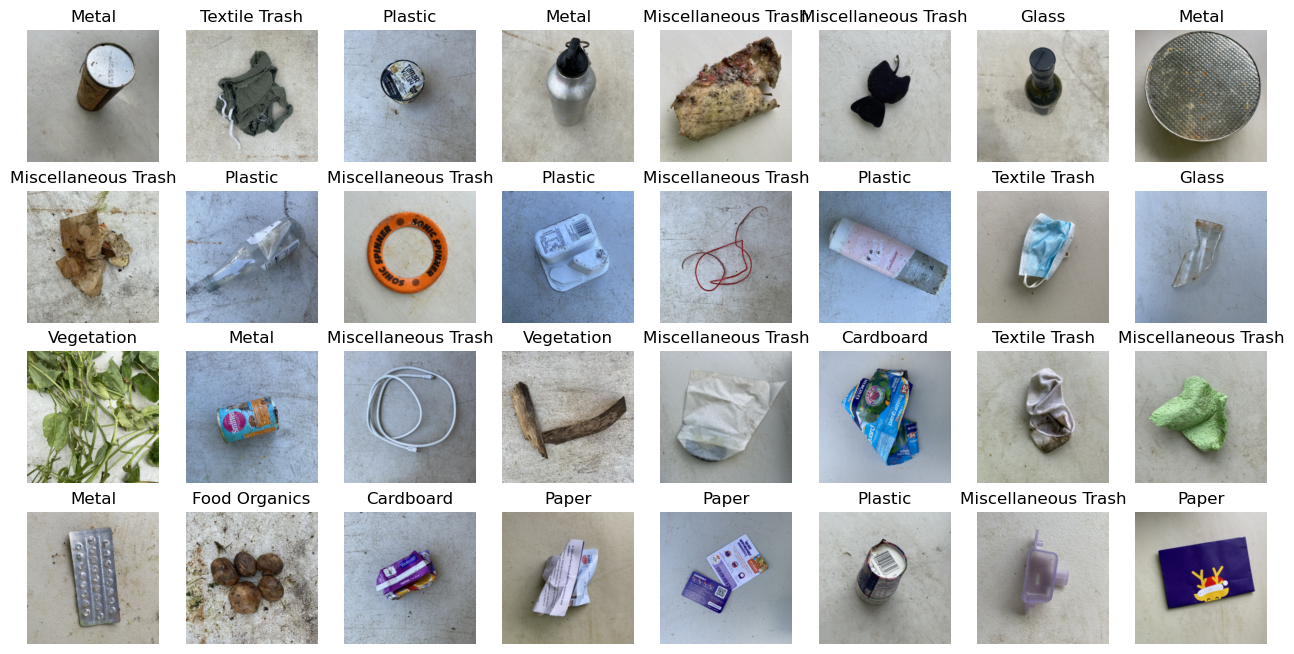

In [6]:
# Visualisation of a batch of train dataset images

def prep(x):
    x = x.numpy().transpose((1, 2, 0))
    m = np.array([0.485, 0.456, 0.406])
    s = np.array([0.229, 0.224, 0.225])
    x = (s * x) + m
    return np.clip(x, 0, 1)
    
images, classes = next(iter(data_loader))

labels_map = {idx: label for label, idx in dataset.class_to_idx.items()}

fig = plt.figure(figsize=(16, 8))
cols, rows = 8, 4
for i in range(32):
    fig.add_subplot(rows, cols, i + 1)
    plt.title(labels_map[int(classes[i])])
    plt.axis('off')
    plt.imshow(prep(images[i]))
plt.show()

As seen, the correct classification is a challenging problem – there is lots of variation in shape, colour, and texture within each class and overall in those features with other classes. Moreover, the miscellaneous trash category is probably not very well-defined.

## Fine-tuning and evaluation

For our waste classification model, we chose to fine-tune ResNet18 (pre-trained on ImageNet), due to its superior performance for its size, allowing convenient training on a consumer CPU.

ResNet is a deep convolutional neural network (CNN) architecture introduced in 2015.

There are various variants of ResNet, with different numbers of layers (ResNet18 has 18), but all the same basic architecture – the key innovation introduced by ResNet was that of *residual connections*, which allowed the stable training of much deeper networks, and which are also used in more modern architectures such as transformers.

There are two main kinds of fine-tuning of deep learning models:
1. One replaces the final classifier layer and updates the weights of the whole network using the training dataset. Thus the pre-trained weights serve as a useful initialisation for a small amount of further training on the downstream task. 
2. One freezes most weights and just updates the weights of a new final layer. Hence the pre-trained network serves as a feature extractor for the downstream task. Even better than just inputting the final layer representations into a classifier, one can take representations from layers all throughout the network, since different layers should be useful for different aspects of the task.

Here we fine-tune according to the first method, using stochastic gradient descent with momentum.

An interesting alternative to the fine-tuning deep CNN approach here, would be a fine-tuned e.g. vision transformer model.

In [7]:
# Load pre-trained model and reset the final fully connected layer

model = models.resnet18(weights = 'IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 9)

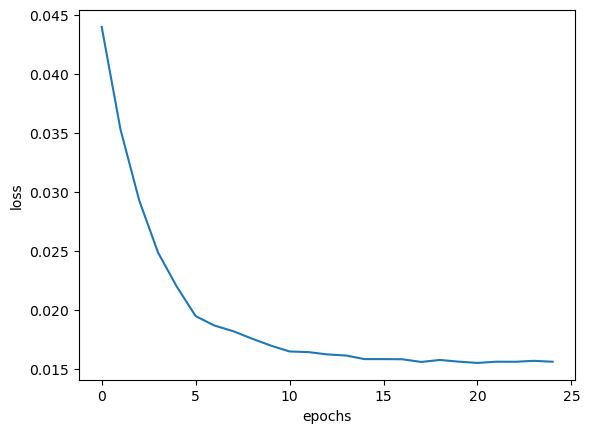

In [39]:
# Fine-tuning

epochs = []
training_losses = []

loss_function = nn.CrossEntropyLoss()
optimiser = SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = StepLR(optimiser, step_size = 5, gamma = 0.3)
    
for epoch in range(25):
    epochs.append(epoch)
    epoch_loss = 0.0
    for i, batch in enumerate(data_loader):
        batch_X, batch_y = batch
        optimiser.zero_grad()
        loss = loss_function(model(batch_X), batch_y)
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
    training_losses.append(epoch_loss)
    scheduler.step()
        
plt.plot(np.array(epochs), np.array(training_losses))

plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

In [41]:
# Save fine-tuned model

save(model.state_dict(), 'C:\\Users\\chris\\Documents\\garbage_classification\\ft_model.pt')

We now evaluate the fine-tuned model.

In [57]:
# Define wrapper function for testing

model.eval()

def pred(x):
    with no_grad():
        return argmax(nn.functional.softmax(model(x.unsqueeze(0)), dim = 1))

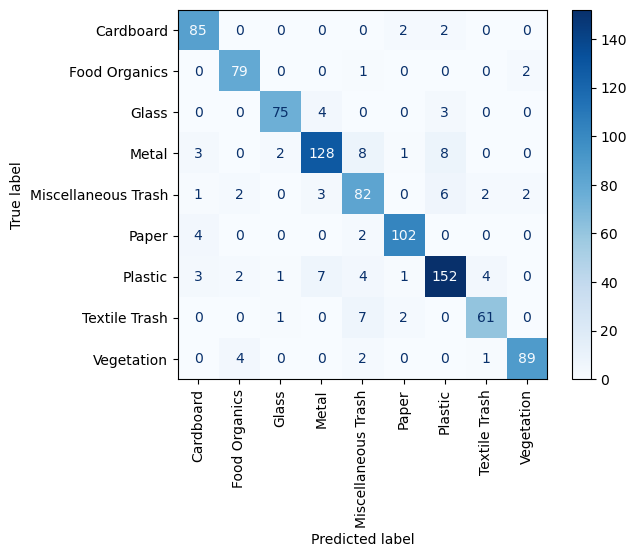

The accuracy is: 0.898


In [58]:
# Evaluate fine-tuned model
    
ConfusionMatrixDisplay.from_predictions([c for (x, c) in test_dataset], [pred(x) for (x, c) in test_dataset], display_labels = [labels_map[n] for n in range(9)], xticks_rotation = 'vertical', cmap = 'Blues')
plt.show()
    
print('The accuracy is:', round(accuracy_score([c for (x, c) in test_dataset], [pred(x) for (x, c) in test_dataset]), 3))

As seen, the results are extremely good, as expected due to the initial representations from the ResNet.

Looking at the misclassifications, we note that many of them are 'semantically meaningful'/ a human might make similar misclassifications: paper is sometimes confused with cardboard and vice versa, glass with plastic, vegetation with food organics and vice versa.

For real-world deployment one would want to fine-tune using images from the locations that the final system would interact with, and maybe use uncertainty quantification to make the system more reliable.